In [ ]:
from models.run_models import *
from utils.correlations import *
from utils.scoring import *
from data.featurize import ddg_to_ee

import json
from collections import Counter
from copy import deepcopy

In [2]:
master_df = pd.read_csv('../../dataset_files/transaminase_dataset_dft_descriptors_boltzmann_final.csv', converters=converters)

enzymes = list(set(master_df['Enzyme'].to_list()))
enzymes.sort()

feature_types = ['ohe', 'fgp', 'physchem', 'dft', 'physchemdft']
dft_colnames = ['Mapped_Ketone', 'Carbon1_Idx', 'Carbonyl_Idx', 'Carbon2_Idx', 'MoleculeFeatures', 'Carbon1_AtomFeatures', 'Carbonyl_AtomFeatures', 'Carbon2_AtomFeatures', 'CC1_Sterimol', 'CC2_Sterimol']

## CONVERSION MODELING

In [14]:
target_type = 'conversion'
model_type = 'rf'
task_type = 'bin'

results_dfs = []

for enzyme in enzymes:
    print(enzyme)
    enzyme_df = master_df[master_df['Enzyme'] == enzyme].reset_index(drop=True)
    for feature_type in feature_types:           
        targets, probs = perform_loocv_on_enzyme(enzyme_df, model_type, task_type, feature_type, target_type)
        preds = [0 if y <= 0.5 else 1 for y in list(probs)]
        enzyme_df[f'Probs_{target_type}_{feature_type}'] = probs
        enzyme_df[f'Predicted_{target_type}_{feature_type}'] = preds
    results_dfs.append(enzyme_df)

#concatenate per-enzyme df's 
res_df_conv = pd.concat(results_dfs)
res_df_conv = res_df_conv.drop(columns=dft_colnames)

Enz1
Enz2
Enz3
Enz4
Enz6
Enz7
Enz8
Enz9


In [15]:
res_df_conv['ACTUAL_BIN'] = get_target_data(res_df_conv['conversion'].to_list(), task_type = 'bin', target_type = 'conversion')

## ee/ddG MODELING

In [3]:
master_df = master_df.dropna(subset=['ee']).reset_index(drop=True) # remove rxns with no experimental ee measurement
master_df.shape

(233, 29)

### First for random forest models

In [ ]:
target_types = ['ddg']
model_type = 'rf' 
task_type = 'reg' 

results_dfs = []

for enzyme in enzymes:
    print(enzyme)
    enzyme_df = master_df[master_df['Enzyme'] == enzyme].reset_index(drop=True)
    for feature_type in feature_types:
        for target_type in target_types:            
            targets, preds = perform_loocv_on_enzyme(enzyme_df, model_type, task_type, feature_type, target_type)
            enzyme_df[f'Predicted_{target_type}_{feature_type}'] = preds
    results_dfs.append(enzyme_df)

#concatenate per-enzyme df's 
res_df_rf = pd.concat(results_dfs)
res_df_rf = res_df_rf.drop(columns=dft_colnames)

Enz1
Enz2
Enz3
Enz4
Enz6
Enz7
Enz8
Enz9


### Now for MVLR models

In [4]:
target_types = ['ddg']
results_dfs = []
selected_features_ddg = {}

for enzyme in enzymes:
    enzyme_df = master_df[master_df['Enzyme'] == enzyme].reset_index(drop=True)
    for target_type in target_types:
        # get correlations
        corr_df = calc_all_correlations(master_df, enzymes, target_type)

        overall_top_descs, best_overall_r2, preds = perform_forward_mvlr(master_df, corr_df, enzyme, target_type)
        enzyme_df[f'Predicted_{target_type}_mvlr'] = preds

        if target_type == 'ddg': selected_features_ddg[enzyme] = overall_top_descs
    results_dfs.append(enzyme_df)

#concatenate per-enzyme df's 
res_df_mvlr = pd.concat(results_dfs)
res_df_mvlr = res_df_mvlr.drop(columns=dft_colnames)

Enz1:
The 1 most correlated descriptor is: VBur.Carbonyl

Now running all 2-parameter models...
The best features were ['VBur.Carbonyl', 'ES_root_dipole'], giving an R2 of 0.23231779825319432

Now running all 3-parameter models...
The best features were ['VBur.Carbonyl', 'ES_root_dipole', 'B1.CC2'], giving an R2 of 0.3402803373201685

Now running all 4-parameter models...
The best features were ['VBur.Carbonyl', 'ES_root_dipole', 'B1.CC2', 'NPA_core.Carbon2'], giving an R2 of 0.3408466137244399

Now running all 5-parameter models...
The best features were ['VBur.Carbonyl', 'ES_root_dipole', 'B1.CC2', 'NPA_core.Carbon2', 'APT_charge.Carbon2'], giving an R2 of 0.34788855279303676

Now running all 6-parameter models...
The best features were ['VBur.Carbonyl', 'ES_root_dipole', 'B1.CC2', 'NPA_core.Carbon2', 'APT_charge.Carbon2', 'ES_root_NPA_core.Carbon1'], giving an R2 of 0.3402197509516902

The overall selected features were ['VBur.Carbonyl', 'ES_root_dipole', 'B1.CC2', 'NPA_core.Carbon2

## Save all results

In [ ]:
results_folder = '../../results/boltzmann_modeling'

# first save conversion
res_df_conv.to_csv(f'{results_folder}/conversion_predictions.csv', index=False)

# combine rf and mvlr regression modeling results and save
for colname in ['Enzyme','Ketone_Smiles','ee','ddg','conversion']:
    assert res_df_rf[colname].to_list() == res_df_mvlr[colname].to_list()

for target_type in ['ddg']:
    res_df_rf[f'Predicted_{target_type}_mvlr'] = res_df_mvlr[f'Predicted_{target_type}_mvlr'].to_list()

res_df_rf.to_csv(f'{results_folder}/selectivity_predictions.csv', index=False)

# save best selected features from mvlr modeling

with open(f'{results_folder}/selected_features_ddg.json', 'w') as f:
    json.dump(selected_features_ddg, f, indent=4)

## Analyze results

In [ ]:
results_folder = '../../results/boltzmann_modeling'
res_df = pd.read_csv(f'{results_folder}/selectivity_predictions.csv') # grab the file that was just saved

['iPr-aryl', 'ethyl-aryl', 'alkyl-alkyl', 'CF3', 'cyclic', 'hydroxymethyl-aryl', 'methyl-aryl', 'cyPr-aryl']
Enz1 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'cyclic']
Enz2 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'cyclic']
Enz3 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'iPr-aryl', 'cyPr-aryl', 'cyclic']
Enz4 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'iPr-aryl', 'cyPr-aryl', 'cyclic']
Enz6 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'cyPr-aryl', 'CF3', 'cyclic']
Enz7 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'iPr-aryl', 'cyPr-aryl', 'CF3', 'cyclic']
Enz8 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'CF3', 'cyclic']
Enz9 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'iPr-aryl', 'CF3', 'cyclic']


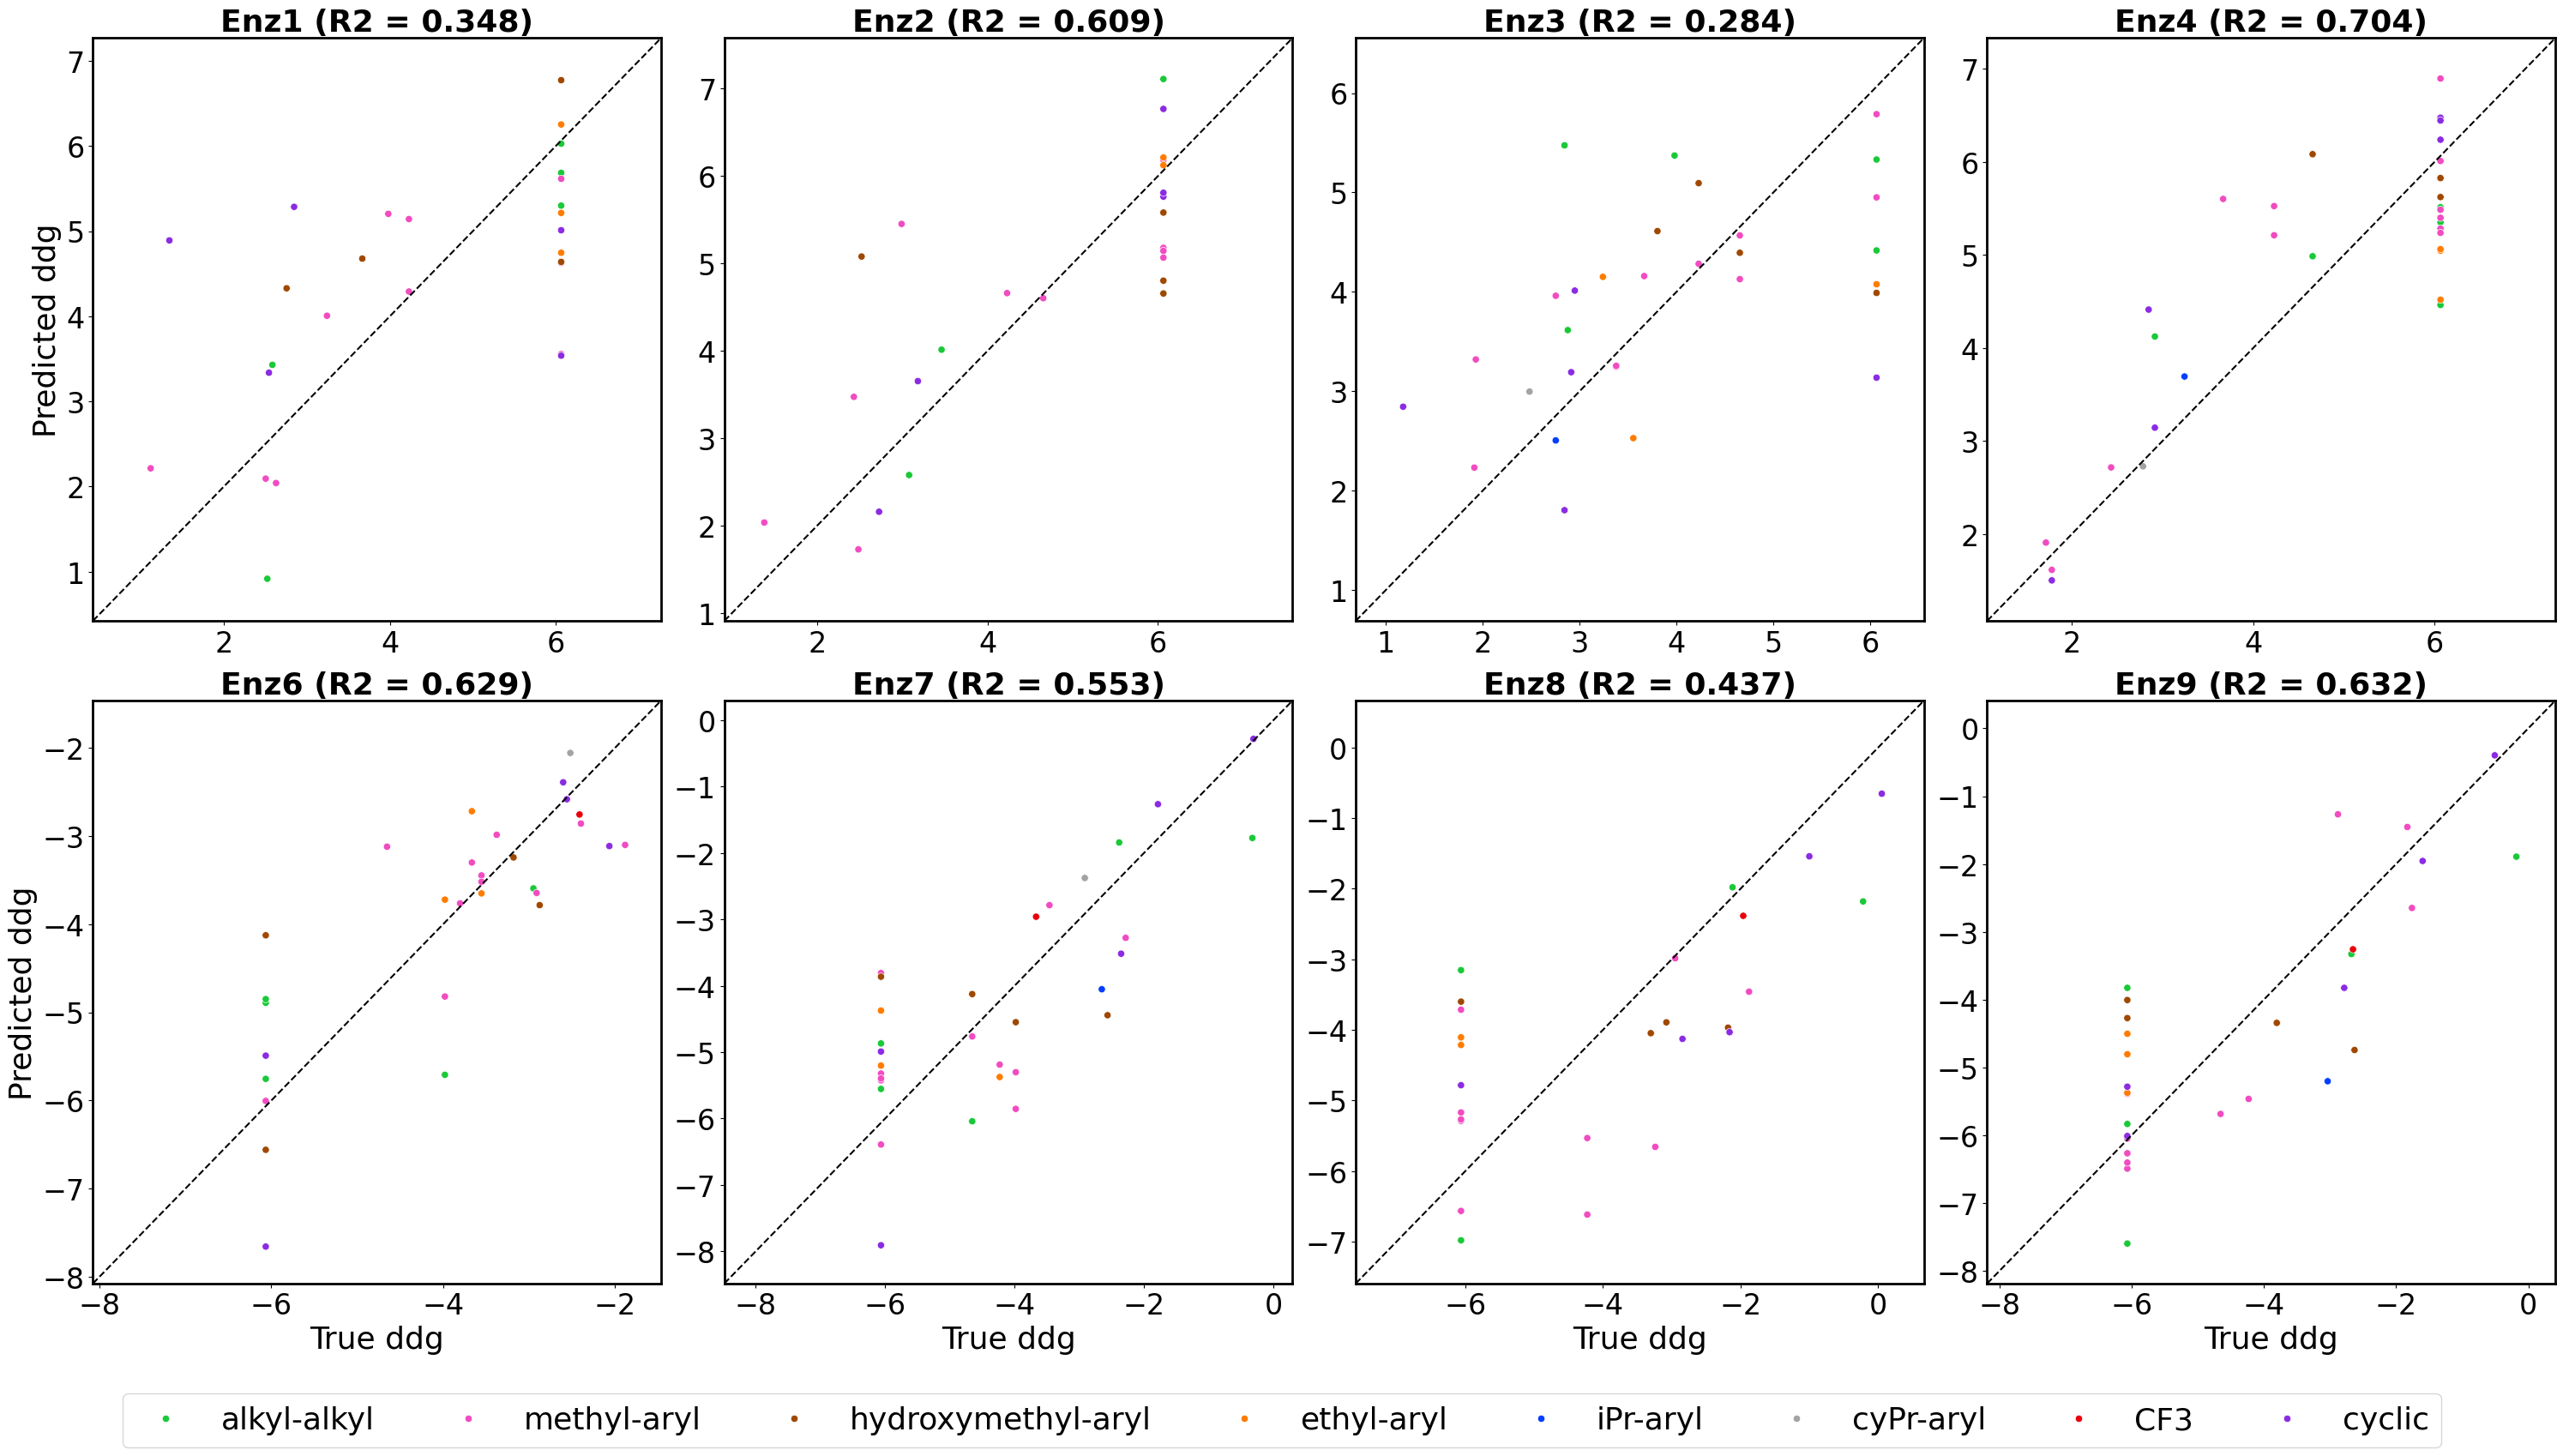

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

# plot MLVR parity plots
SMALL_SIZE = 24
matplotlib.rcParams['axes.linewidth'] = 2
plt.rc('axes', labelsize=SMALL_SIZE+2)
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE+2)    # legend fontsize

target_type = 'ddg'
enzymes = ['Enz1','Enz2','Enz3','Enz4','Enz6','Enz7','Enz8','Enz9']
ketone_types = list(set(master_df['Ketone_Type'].to_list()))
print(ketone_types)
colors = dict(zip(ketone_types, sns.color_palette('bright', 10)))
ncols,nrows = 4,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(30, nrows*8), tight_layout=True)
#axmin = min(res_df[target_type].to_list()) - 0.1*(max(res_df[target_type].to_list()))
#axmax = max(res_df[target_type].to_list()) + 0.1*(max(res_df[target_type].to_list()))

for i,enzyme in enumerate(enzymes):
    xa,ya = math.floor(i/ncols),i%ncols
    #overall_top_descs, best_overall_r2, enzyme_df = perform_forward_mvlr(master_df, enzyme, target_type)
    enzyme_df = res_df[res_df['Enzyme'] == enzyme]
    print(enzyme, list(enzyme_df['Ketone_Type'].unique()))
    y_true = np.array(enzyme_df[f'{target_type}'].to_list())
    y_pred = np.array(enzyme_df[f'Predicted_{target_type}_mvlr'].to_list())
    r2 = r2_score(y_true, y_pred)
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    axes[xa,ya].set_xlim((axmin, axmax))
    axes[xa,ya].set_ylim((axmin, axmax))
    #if target_type == 'ee': axmin, axmax = 0, 100
    sns.scatterplot(enzyme_df,x=target_type,y=f'Predicted_{target_type}_mvlr',hue='Ketone_Type',palette=colors,ax=axes[xa,ya])
    axes[xa,ya].plot([axmin, axmax], [axmin, axmax], '--k')
    axes[xa,ya].set_title(f'{enzyme} (R2 = {r2:.3f})', fontweight='bold', fontsize=SMALL_SIZE+2)
    if xa==1: axes[xa,ya].set_xlabel(f'True {target_type}')
    else: axes[xa,ya].set_xlabel('')
    if ya==0: axes[xa,ya].set_ylabel(f'Predicted {target_type}')
    else: axes[xa,ya].set_ylabel('')
    axes[xa,ya].legend_ = None
handles,labels = axes[1,1].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.3, wspace=0.33)
legend = fig.legend(handles, labels, loc=('lower center'), bbox_to_anchor=(0.5,-0.07), ncol=nrows*ncols)

['hydroxymethyl-aryl', 'CF3', 'cyclic', 'methyl-aryl', 'iPr-aryl', 'cyPr-aryl', 'ethyl-aryl', 'alkyl-alkyl']
Enz1 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'cyclic']
Enz2 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'cyclic']
Enz3 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'iPr-aryl', 'cyPr-aryl', 'cyclic']
Enz4 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'iPr-aryl', 'cyPr-aryl', 'cyclic']
Enz6 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'cyPr-aryl', 'CF3', 'cyclic']
Enz7 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'iPr-aryl', 'cyPr-aryl', 'CF3', 'cyclic']
Enz8 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'CF3', 'cyclic']
Enz9 ['alkyl-alkyl', 'methyl-aryl', 'hydroxymethyl-aryl', 'ethyl-aryl', 'iPr-aryl', 'CF3', 'cyclic']


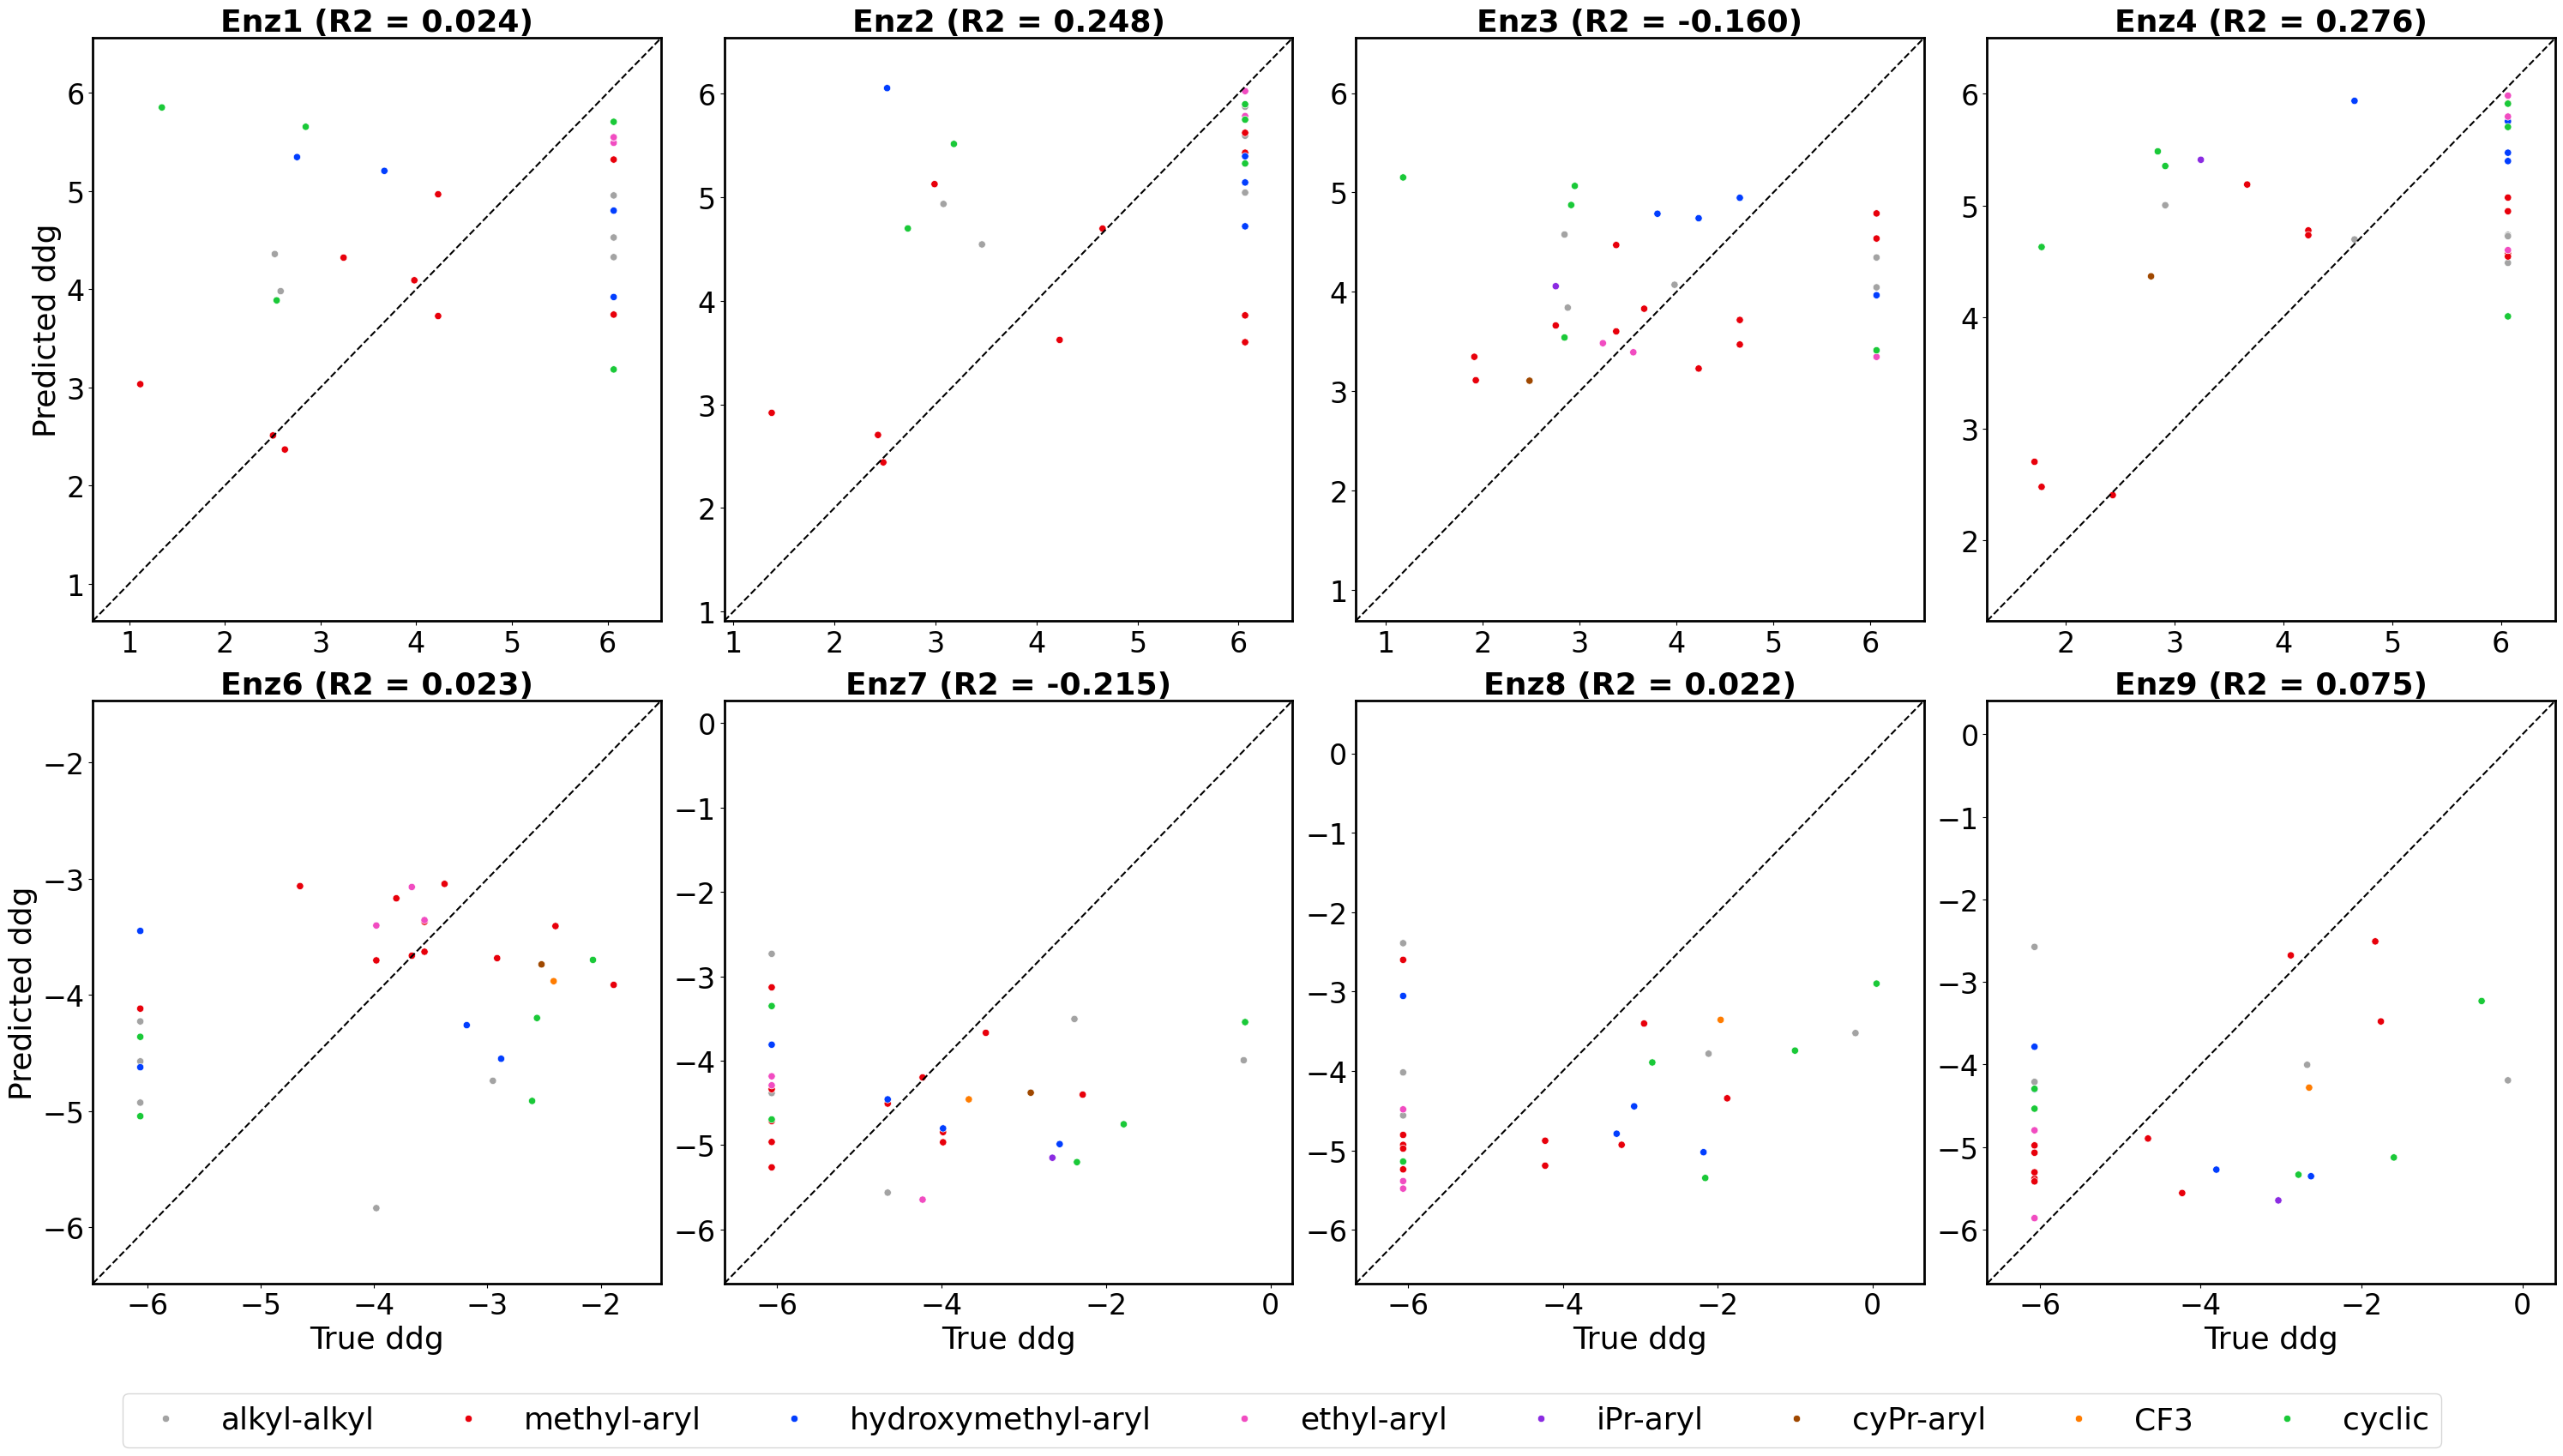

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

# plot MLVR parity plots
SMALL_SIZE = 24
matplotlib.rcParams['axes.linewidth'] = 2
plt.rc('axes', labelsize=SMALL_SIZE+2)
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE+2)    # legend fontsize

target_type = 'ddg'
enzymes = ['Enz1','Enz2','Enz3','Enz4','Enz6','Enz7','Enz8','Enz9']
ketone_types = list(set(master_df['Ketone_Type'].to_list()))
print(ketone_types)
colors = dict(zip(ketone_types, sns.color_palette('bright', 10)))
ncols,nrows = 4,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(30, nrows*8), tight_layout=True)
#axmin = min(res_df[target_type].to_list()) - 0.1*(max(res_df[target_type].to_list()))
#axmax = max(res_df[target_type].to_list()) + 0.1*(max(res_df[target_type].to_list()))

for i,enzyme in enumerate(enzymes):
    xa,ya = math.floor(i/ncols),i%ncols
    #overall_top_descs, best_overall_r2, enzyme_df = perform_forward_mvlr(master_df, enzyme, target_type)
    enzyme_df = res_df[res_df['Enzyme'] == enzyme]
    print(enzyme, list(enzyme_df['Ketone_Type'].unique()))
    y_true = np.array(enzyme_df[f'{target_type}'].to_list())
    y_pred = np.array(enzyme_df[f'Predicted_{target_type}_dft'].to_list())
    r2 = r2_score(y_true, y_pred)
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    axes[xa,ya].set_xlim((axmin, axmax))
    axes[xa,ya].set_ylim((axmin, axmax))
    #if target_type == 'ee': axmin, axmax = 0, 100
    sns.scatterplot(enzyme_df,x=target_type,y=f'Predicted_{target_type}_dft',hue='Ketone_Type',palette=colors,ax=axes[xa,ya])
    axes[xa,ya].plot([axmin, axmax], [axmin, axmax], '--k')
    axes[xa,ya].set_title(f'{enzyme} (R2 = {r2:.3f})', fontweight='bold', fontsize=SMALL_SIZE+2)
    if xa==1: axes[xa,ya].set_xlabel(f'True {target_type}')
    else: axes[xa,ya].set_xlabel('')
    if ya==0: axes[xa,ya].set_ylabel(f'Predicted {target_type}')
    else: axes[xa,ya].set_ylabel('')
    axes[xa,ya].legend_ = None
handles,labels = axes[1,1].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.3, wspace=0.33)
legend = fig.legend(handles, labels, loc=('lower center'), bbox_to_anchor=(0.5,-0.07), ncol=nrows*ncols)

In [8]:
# calculate all per-enzyme regression metrics for all feature types 
target_type = 'ddg'
for feature_type in feature_types + ['mvlr']:
    print(feature_type)
    for enzyme in enzymes:
        sub_res_df = res_df[res_df['Enzyme'] == enzyme]
        y_test = sub_res_df[target_type].to_list()
        y_pred = sub_res_df[f'Predicted_{target_type}_{feature_type}'].to_list()

        r2 = r2_score(y_test,y_pred)
        pearson = pearsonr(y_test,y_pred).statistic
        mae = mean_absolute_error(y_test,y_pred)
        print(f'{enzyme}: {r2:.3f}  {pearson:.3f} {mae:.3f}')
    print()

ohe
Enz1: -0.666  -0.833 1.844
Enz2: -0.617  -0.617 1.312
Enz3: -0.362  -0.646 1.305
Enz4: -0.630  -0.672 1.326
Enz6: -0.198  -0.731 1.214
Enz7: -0.724  -0.619 1.811
Enz8: -0.755  -0.652 2.115
Enz9: -0.742  -0.293 1.733

fgp
Enz1: -0.181  0.045 1.605
Enz2: -0.208  0.016 1.430
Enz3: 0.027  0.229 1.141
Enz4: -0.066  0.234 1.300
Enz6: -0.307  -0.146 1.320
Enz7: -0.348  -0.117 1.739
Enz8: -0.347  -0.040 2.096
Enz9: 0.037  0.274 1.655

physchem
Enz1: -0.405  -0.292 1.830
Enz2: -0.138  0.057 1.480
Enz3: -0.317  -0.273 1.397
Enz4: -0.074  0.141 1.393
Enz6: -0.030  0.161 1.205
Enz7: -0.186  -0.086 1.659
Enz8: -0.151  -0.041 1.964
Enz9: -0.094  0.048 1.829

dft
Enz1: 0.024  0.309 1.365
Enz2: 0.248  0.516 1.052
Enz3: -0.160  0.045 1.259
Enz4: 0.276  0.532 1.099
Enz6: 0.023  0.265 1.204
Enz7: -0.215  -0.068 1.666
Enz8: 0.022  0.256 1.784
Enz9: 0.075  0.337 1.587

physchemdft
Enz1: -0.174  0.025 1.596
Enz2: 0.094  0.350 1.242
Enz3: -0.250  -0.167 1.342
Enz4: 0.149  0.397 1.236
Enz6: -0.033  0.167 

In [23]:
# calculate all overall regression metrics for all feature types 
target_type = 'ddg'
for feature_type in feature_types + ['mvlr']:
    print(feature_type)
    y_test = res_df[target_type].to_list()
    y_pred = res_df[f'Predicted_{target_type}_{feature_type}'].to_list()

    # abs ddg values since we're looking across all enzymes now
    y_test = [abs(i) for i in y_test]
    y_pred = [abs(i) for i in y_pred]

    r2 = r2_score(y_test,y_pred)
    pearson = pearsonr(y_test,y_pred).statistic
    mae = mean_absolute_error(y_test,y_pred)
    print(f'Overall: {r2:.3f}  {pearson:.3f} {mae:.3f}')
    print()

ohe
Overall: -0.572  0.071 1.577

fgp
Overall: -0.140  0.144 1.530

physchem
Overall: -0.132  0.050 1.588

dft
Overall: 0.066  0.332 1.377

physchemdft
Overall: -0.062  0.150 1.515

mvlr
Overall: 0.543  0.745 0.940



In [12]:
# also calculate all per-enzyme mae metrics in terms of ee for all feature types 
target_type = 'ddg'
for feature_type in feature_types + ['mvlr']:
    print(feature_type)
    for enzyme in enzymes:
        sub_res_df = res_df[res_df['Enzyme'] == enzyme]
        y_test_ddg = sub_res_df['ddg'].to_list()
        y_test_ee = sub_res_df['ee'].to_list()
        y_pred = sub_res_df[f'Predicted_{target_type}_{feature_type}'].to_list()

        #y_test_ee = [abs(i) for i in y_test_ee]
        y_pred_ee = [ddg_to_ee(i) for i in y_pred]

        mae = mean_absolute_error(y_test_ee,y_pred_ee)
        print(f'{enzyme}: {mae:.3f}')
    print()

ohe
Enz1: 2.578
Enz2: 1.406
Enz3: 2.209
Enz4: 1.424
Enz6: 1.366
Enz7: 5.895
Enz8: 9.293
Enz9: 6.690

fgp
Enz1: 2.582
Enz2: 1.419
Enz3: 1.948
Enz4: 1.461
Enz6: 1.370
Enz7: 5.928
Enz8: 9.225
Enz9: 6.573

physchem
Enz1: 2.682
Enz2: 1.422
Enz3: 2.132
Enz4: 1.476
Enz6: 1.340
Enz7: 5.917
Enz8: 9.421
Enz9: 6.687

dft
Enz1: 2.391
Enz2: 1.165
Enz3: 1.990
Enz4: 1.145
Enz6: 1.374
Enz7: 5.974
Enz8: 9.403
Enz9: 6.599

physchemdft
Enz1: 2.561
Enz2: 1.290
Enz3: 2.061
Enz4: 1.348
Enz6: 1.362
Enz7: 5.978
Enz8: 9.453
Enz9: 6.717

mvlr
Enz1: 3.512
Enz2: 1.314
Enz3: 1.969
Enz4: 0.590
Enz6: 1.015
Enz7: 3.329
Enz8: 6.406
Enz9: 4.729



In [7]:
# also calculate all overall mae metrics in terms of ee for all feature types 
target_type = 'ddg'
for feature_type in feature_types + ['mvlr']:
    print(feature_type)
    y_test_ddg = res_df['ddg'].to_list()
    y_test_ee = res_df['ee'].to_list()
    y_pred = res_df[f'Predicted_{target_type}_{feature_type}'].to_list()

    y_pred_ee = [ddg_to_ee(i) for i in y_pred]

    mae = mean_absolute_error(y_test_ee,y_pred_ee)
    print(f'Overall: {mae:.3f}')
    print()

ohe
Overall: 3.845

fgp
Overall: 3.801

physchem
Overall: 3.871

dft
Overall: 3.743

physchemdft
Overall: 3.834

mvlr
Overall: 2.820

